In [2]:
#from BirdExplore import BirdsData
import os
import seaborn as sns
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm

from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#!ls "/content/drive/My Drive/AI_JKU/MLPC"
#loading our dataset CONNECT YOUR GOOGLE DRIVE AND CHANGE DERICTORY
dataset = pd.read_csv('/content/drive/My Drive/AI_JKU/MLPC/bird.csv')

# Data Split:

For the cross-validation split, we are going to use stratified k-fold cross-validation since the dataset has an imbalanced class distribution. This method ensures that each fold has approximately the same proportion of each class. We can then use the average performance across all folds as the final performance estimate. 

The choice of k in k-fold cross-validation depends on the size of our dataset and the balance between the number of samples in each class. In our case, the majority class "other" has 85358 samples, which is about 71% of the entire dataset. It's important to make sure that each fold in the cross-validation contains a representative sample of each class.

The cross-validation was performed with 5 splits. StratifiedKFold is a good choice when dealing with imbalanced datasets, as it ensures that the class distribution is maintained in each fold. The shuffle parameter was set to True to randomize the data before splitting.

# Features:
Since the dataset has a large number of features, feature selection or dimensionality reduction techniques could be applied to reduce the number of features and improve the performance of the algorithm. One way to select features is to use feature importance scores provided by the random forest algorithm itself. Alternatively, techniques such as principal component analysis (PCA) or linear discriminant analysis (LDA) could be used to reduce the dimensionality of the data. Additionally, data preprocessing techniques such as normalization or standardization could be applied to scale the features to a similar range.

# Evaluation: 

The evaluation criteria used in the code include accuracy, precision, recall, F1-score, and AUC-ROC. These metrics provide a comprehensive view of the model's performance in terms of classification accuracy, precision (weighted average), recall (weighted average), F1-score (weighted average), and the area under the ROC curve. 

In [4]:
# Get a list of all feature names in the dataset
feature_names = list(dataset.columns)

# Define a list of keywords to filter the feature names by
keywords = ['cln_melspect_mean', 'cln_contrast_mean', 'cln_mfcc_mean', 'cln_power_mean', 'cln_energy_mean', 
            'cln_centroid_mean', 'cln_flatness_mean', 'cln_melspect_std', 'cln_mfcc_std',
            'raw_contrast_mean', 'raw_melspect_mean', 'raw_mfcc_mean', 'raw_flux_std',
            'raw_melspect_std', 'raw_mfcc_std', 'raw_power_std', 'raw_energy_std',
            'yin']

# Filter the feature names to only include those that contain one of the keywords
selected_features = [name for name in feature_names if any(keyword in name for keyword in keywords)]

# Add the target column to the selected features
selected_features.append('target')

# Select only the filtered columns from the original dataset
ds_filtered = dataset[selected_features]

# Assign the filtered dataset to the original variable
ds = ds_filtered

print(ds)


            yin_0        yin_1       yin_2       yin_3       yin_4  \
0       490.95706   491.753000   488.98358   485.07758   469.73868   
1       467.41357   516.481700   515.56213   514.21027   509.39246   
2       511.84506   508.178220   509.49075   509.44510   513.54913   
3       514.25470   512.569800  4576.39400  4567.56050  4576.48800   
4       462.35953  4722.730500  4718.76900  4696.35940  4698.63870   
...           ...          ...         ...         ...         ...   
119995  123.89011   102.581856   138.74265   105.55623   134.43510   
119996  113.35216   132.759500   131.74880   132.74190   137.45901   
119997  112.55479   111.380640   110.19271   139.75227   108.30055   
119998  239.43413   238.842990   247.39948   146.59433   173.95085   
119999  287.17032   142.139500   146.61256   169.66037   168.43490   

              yin_5        yin_6       yin_7       yin_8        yin_9  ...  \
0        513.687100   512.657350   245.04290   514.48834   245.524410  ...   
1  

# Experiments: 

We have experimented with different hyperparameter combinations for a RandomForestClassifier. By varying the hyperparameters, we observed how the classification performance changes and identified the parameter settings that yield the best results. It's also worth exploring other classifiers from different groups (e.g., support vector machines, X gradient boosting) to compare their performance against RandomForestClassifier and investigate how overfitting and classification performance vary across different classifiers.

In [5]:
from imblearn.under_sampling import RandomUnderSampler


concated = ds.reindex(np.random.permutation(ds.index))

concated['LABEL'] = 0

concated.loc[concated['target'] == 'other', 'LABEL'] = 0
concated.loc[concated['target'] == 'cowpig1', 'LABEL'] = 1
concated.loc[concated['target'] == 'eucdov', 'LABEL'] = 2
concated.loc[concated['target'] == 'comcuc', 'LABEL'] = 3
concated.loc[concated['target'] == 'grswoo', 'LABEL'] = 4
concated.loc[concated['target'] == 'tawowl1', 'LABEL'] = 5
concated.loc[concated['target'] == 'eueowl1', 'LABEL'] = 6



concated = concated.drop(['target'], axis=1) # final state of data with int labels

X_array = concated.drop(['LABEL'], axis=1) # pure data without any labels


#concated = concated.sample(frac=1, random_state=42)
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# normalized_data = scaler.fit_transform(X_array)


#X = normalized_data
X = X_array
y = concated['LABEL']
#print("eto y",y)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, index=X.index, columns=X.columns)
# Fit and apply the under-sampler to the data
# under_sampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# select the first 20% of the shuffled indices
n = int(len(X_normalized_df) * 0.2)
X_subset = X_normalized_df[:n]
y_subset = y[:n]

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_normalized = scaler.fit_transform(X_subset)
# X_normalized_df = pd.DataFrame(X_normalized, index=X_subset.index, columns=X_subset.columns)

print(X_subset, y_subset)
print(np.shape(X_subset), np.shape(y_subset))
print(y_subset.value_counts())


# #trying to shuffle 
# num_of_categories = 2320
# shuffled = dataset.reindex(np.random.permutation(dataset.index))
# other = shuffled[shuffled['target'] == 'other'][:num_of_categories]
# cowpig1 = shuffled[shuffled['target'] == 'cowpig1'][:num_of_categories]
# eucdov = shuffled[shuffled['target'] == 'eucdov'][:num_of_categories]
# comcuc = shuffled[shuffled['target'] == 'comcuc'][:num_of_categories]
# grswoo = shuffled[shuffled['target'] == 'grswoo'][:num_of_categories]
# tawowl1 = shuffled[shuffled['target'] == 'tawowl1'][:num_of_categories]
# eueowl1 = shuffled[shuffled['target'] == 'eueowl1'][:num_of_categories]


# concated = pd.concat([other,cowpig1,eucdov,comcuc,grswoo,tawowl1,eueowl1], ignore_index=True)
# #Shuffle the dataset
# concated = concated.reindex(np.random.permutation(concated.index))
# concated['LABEL'] = 0

           yin_0     yin_1     yin_2     yin_3     yin_4     yin_5     yin_6  \
40157   0.005742  0.005790  0.005628  0.038550  0.037319  0.010941  0.010720   
32433   0.037527  0.036017  0.035362  0.035512  0.035308  0.035187  0.034996   
93216   0.398333  0.391084  0.385227  0.381488  0.380691  0.071025  0.005107   
63577   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
6917    0.162932  0.041059  0.041460  0.041436  0.044891  0.045502  0.365133   
...          ...       ...       ...       ...       ...       ...       ...   
17333   0.045160  0.045166  0.045599  0.044659  0.044982  0.045103  0.046643   
31828   0.033534  0.033133  0.002544  0.002977  0.034106  0.003469  0.038904   
101015  0.053732  0.032920  0.032745  0.053963  0.028370  0.054070  0.000566   
27849   0.031525  0.030929  0.031049  0.030736  0.030289  0.030138  0.030266   
72613   0.025570  0.025331  0.024146  0.024155  0.029909  0.032677  0.033267   

           yin_7     yin_8     yin_9  .

In [ ]:
print(np.shape(X_subset), np.shape(y_subset))
print(type(X_subset), type(y_subset))

print(X_subset, y_subset)

In [33]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# selector = SelectKBest(mutual_info_classif, k=100)
# X_new = selector.fit_transform(X_resampled, y_resampled)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from itertools import product

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create a list of all possible hyperparameter combinations
param_list = list(product(*param_grid.values()))

# Initialize an empty list to store results
results = []

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=0)


# Loop over all hyperparameter combinations
for i, params in enumerate(param_list):
    # Print the current hyperparameter setting
    print(f"Running combination {i+1}/{len(param_list)}: {params}")
    
    # Initialize the random forest classifier with the current hyperparameters
    clf = RandomForestClassifier(**dict(zip(param_grid.keys(), params)))
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Predict the labels of the test data
    y_pred = clf.predict(X_test)
    
    # Compute the evaluation metric for this hyperparameter combination
    acc_score = accuracy_score(y_test, y_pred)
    
    # Add the hyperparameter combination and its corresponding accuracy score to the results list
    results.append((params, acc_score))
    
# Sort the results list by accuracy score in descending order
results_unsorted = results
results = sorted(results, key=lambda x: x[1], reverse=True)

# Print the best hyperparameter combination and its corresponding accuracy score
print(f"Best hyperparameters: {results[0][0]}, accuracy score: {results[0][1]}")


Running combination 1/24: (100, 5, 2, 2, 'sqrt')
Running combination 2/24: (100, 5, 2, 2, 'log2')
Running combination 3/24: (100, 5, 2, 4, 'sqrt')
Running combination 4/24: (100, 5, 2, 4, 'log2')
Running combination 5/24: (100, 5, 5, 2, 'sqrt')
Running combination 6/24: (100, 5, 5, 2, 'log2')
Running combination 7/24: (100, 5, 5, 4, 'sqrt')
Running combination 8/24: (100, 5, 5, 4, 'log2')
Running combination 9/24: (100, 10, 2, 2, 'sqrt')
Running combination 10/24: (100, 10, 2, 2, 'log2')
Running combination 11/24: (100, 10, 2, 4, 'sqrt')
Running combination 12/24: (100, 10, 2, 4, 'log2')
Running combination 13/24: (100, 10, 5, 2, 'sqrt')
Running combination 14/24: (100, 10, 5, 2, 'log2')
Running combination 15/24: (100, 10, 5, 4, 'sqrt')
Running combination 16/24: (100, 10, 5, 4, 'log2')
Running combination 17/24: (100, 20, 2, 2, 'sqrt')
Running combination 18/24: (100, 20, 2, 2, 'log2')
Running combination 19/24: (100, 20, 2, 4, 'sqrt')
Running combination 20/24: (100, 20, 2, 4, 'log2

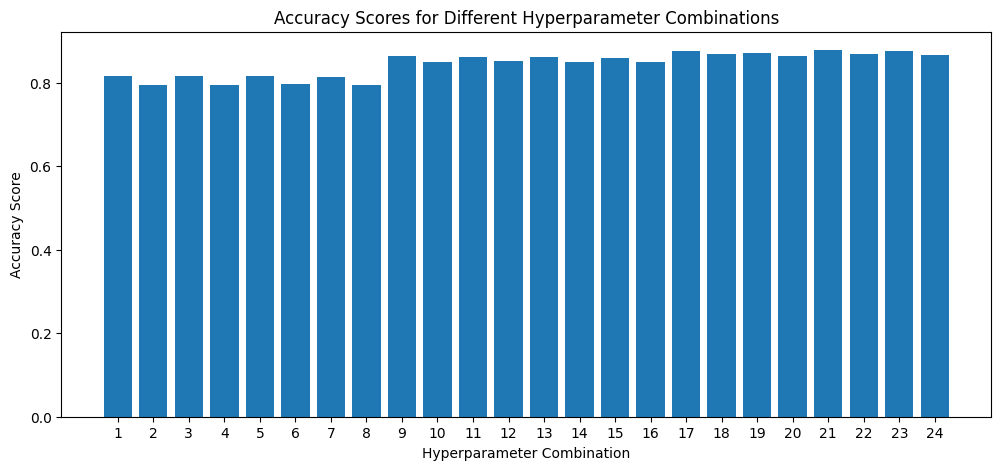

In [20]:
# Plotting the results
accuracy_scores = [result[1] for result in results_unsorted]
x_ticks = np.arange(len(accuracy_scores))

plt.figure(figsize=(12, 5))
plt.bar(x_ticks, accuracy_scores)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Accuracy Score')
plt.xticks(x_ticks, [f"{i+1}" for i in range(len(accuracy_scores))])
plt.title('Accuracy Scores for Different Hyperparameter Combinations')
plt.show()

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the number of folds to iterate over
num_folds = [5, 7, 10]

# Initialize empty lists to store mean evaluation metrics for each number of folds
mean_acc_scores = []
mean_precision_scores = []
mean_recall_scores = []
mean_f1_scores = []
mean_auc_roc_scores = []

# Iterate over different numbers of folds
for n_folds in num_folds:
    # Initialize the cross-validation splitter
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

    # Initialize empty lists to store evaluation metrics for each fold
    acc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_roc_scores = []

    # Loop over all folds of the cross-validation splitter
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_subset, y_subset)):
        # Convert train and test indices to DataFrame indices
        train_indices = X_subset.index[train_idx]
        test_indices = X_subset.index[test_idx]

        # Get the training and testing data for this fold
        X_train, y_train = X_subset.loc[train_indices], y_subset.loc[train_indices]
        X_test, y_test = X_subset.loc[test_indices], y_subset.loc[test_indices]
        
        # Initialize the random forest classifier
        clf = RandomForestClassifier(**dict(zip(param_grid.keys(), results[0][0])))
        
        # Fit the classifier on the training data
        clf.fit(X_train, y_train)
        
        # Predict the labels of the test data
        y_pred = clf.predict(X_test)
        
        # Compute evaluation metrics for this fold
        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        auc_roc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr'))
    
    # Compute the mean evaluation metrics over all folds
    mean_acc = sum(acc_scores) / len(acc_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    mean_auc_roc = sum(auc_roc_scores) / len(auc_roc_scores)

    # Append the mean evaluation metrics to the lists
    mean_acc_scores.append(mean_acc)
    mean_precision_scores.append(mean_precision)
    mean_recall_scores.append(mean_recall)
    mean_f1_scores.append(mean_f1)
    mean_auc_roc_scores.append(mean_auc_roc)
    
    # Print the evaluation metrics for the current number of folds
    print(f"Number of folds: {n_folds}")
    print(f"Mean accuracy: {mean_acc}")
    print(f"Mean precision: {mean_precision}")
    print(f"Mean recall: {mean_recall}")
    print(f"Mean F1-score: {mean_f1}")
    print(f"Mean AUC-ROC: {mean_auc_roc}")
    print()




Number of folds: 5
Mean accuracy: 0.881
Mean precision: 0.8790011605440313
Mean recall: 0.881
Mean F1-score: 0.8731055131780134
Mean AUC-ROC: 0.9717918943089291

Number of folds: 7
Mean accuracy: 0.8828755166786572
Mean precision: 0.8814166072513088
Mean recall: 0.8828755166786572
Mean F1-score: 0.87489108331303
Mean AUC-ROC: 0.9723100192191031

Number of folds: 10
Mean accuracy: 0.8837916666666666
Mean precision: 0.8822241862885182
Mean recall: 0.8837916666666666
Mean F1-score: 0.8759993828519426
Mean AUC-ROC: 0.9729248154575583



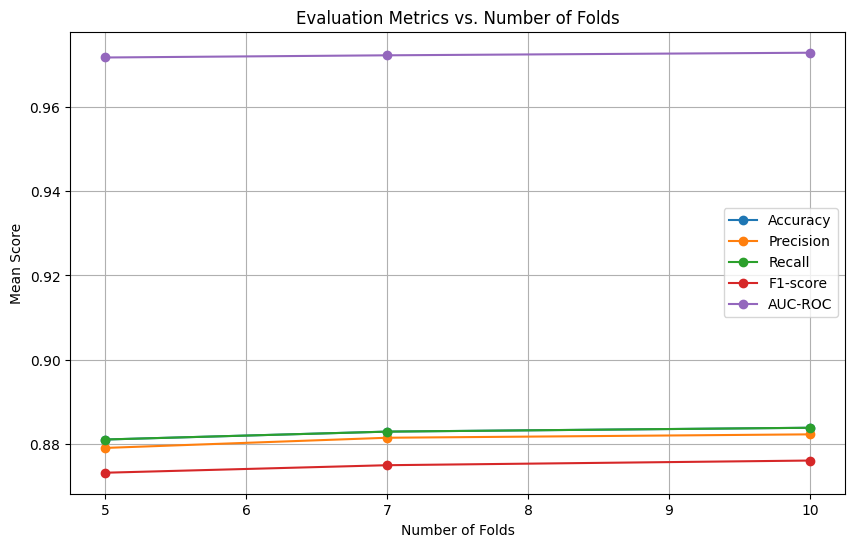

In [32]:
# Plotting the evaluation metrics based on the number of folds
plt.figure(figsize=(10, 6))
plt.plot(num_folds, mean_acc_scores, marker='o', label='Accuracy')
plt.plot(num_folds, mean_precision_scores, marker='o', label='Precision')
plt.plot(num_folds, mean_recall_scores, marker='o', label='Recall')
plt.plot(num_folds, mean_f1_scores, marker='o', label='F1-score')
plt.plot(num_folds, mean_auc_roc_scores, marker='o', label='AUC-ROC')
plt.xlabel('Number of Folds')
plt.ylabel('Mean Score')
plt.title('Evaluation Metrics vs. Number of Folds')
plt.legend()
plt.grid(True)
plt.show()

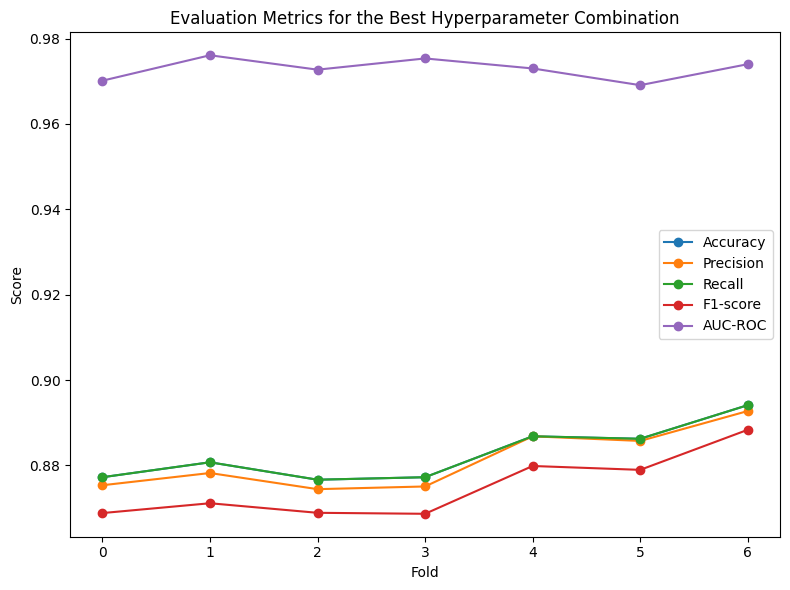

Mean accuracy: 0.8827091260616928
Mean precision: 0.8811854484493662
Mean recall: 0.8827091260616928
Mean F1-score: 0.8749467625215432
Mean AUC-ROC: 0.9729122431076467


In [30]:
# Plot the evaluation metrics for the best hyperparameter combination
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(range(cv.get_n_splits(X_subset, y_subset)), acc_scores, marker='o', label='Accuracy')
plt.plot(range(cv.get_n_splits(X_subset, y_subset)), precision_scores, marker='o', label='Precision')
plt.plot(range(cv.get_n_splits(X_subset, y_subset)), recall_scores, marker='o', label='Recall')
plt.plot(range(cv.get_n_splits(X_subset, y_subset)), f1_scores, marker='o', label='F1-score')
plt.plot(range(cv.get_n_splits(X_subset, y_subset)), auc_roc_scores, marker='o', label='AUC-ROC')
plt.xlabel('Fold')
plt.ylabel('Score')
# plt.xticks(x_ticks, [f"{i+1}" for i in range(5)])
plt.title('Evaluation Metrics for the Best Hyperparameter Combination')
plt.legend()
plt.tight_layout()
plt.show()



 N = 7

 Mean accuracy: 0.8823333333333332

 Mean precision: 0.8805740866312355

 Mean recall: 0.8823333333333332
 
 Mean F1-score: 0.8742985716927146

 Mean AUC-ROC: 0.971729773500372


In [ ]:
# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from itertools import product

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
#     #'max_features': ['sqrt', 'log2', None]
# }

# # Create a list of all possible hyperparameter combinations
# param_list = list(product(*param_grid.values()))

# # Initialize an empty list to store results
# results = []

# # Initialize the cross-validation splitter
# # cv = StratifiedShuffleSplit(n_splits=7, test_size=0.25, random_state=0)
# cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)

# # Loop over all hyperparameter combinations
# for i, params in enumerate(param_list):
    
#     # Print the current hyperparameter setting
#     print(f"Running combination {i+1}/{len(param_list)}: {params}")
    
#     # Initialize the random forest classifier with the current hyperparameters
#     clf = RandomForestClassifier(**dict(zip(param_grid.keys(), params)))
    
#     # Initialize empty lists to store evaluation metrics for each fold
#     acc_scores = []
#     precision_scores = []
#     recall_scores = []
#     f1_scores = []
#     auc_roc_scores = []
    
#     # Loop over all folds of the cross-validation splitter
#     for train_idx, test_idx in cv.split(X_subset, y_subset):

#         # Convert train and test indices to DataFrame indices
#         train_indices = X_subset.index[train_idx]
#         test_indices = X_subset.index[test_idx]

#         # Get the training and testing data for this fold
#         X_train, y_train = X_subset.loc[train_indices], y_subset.loc[train_indices]
#         X_test, y_test = X_subset.loc[test_indices], y_subset.loc[test_indices]
        
#         # Get the training and testing data for this fold
#         # X_train, y_train = X_subset[train_idx], y_subset[train_idx]
#         # X_test, y_test = X_subset[test_idx], y_subset[test_idx]
#         #print(train_idx, test_idx)
        
#         # Fit the classifier on the training data
#         clf.fit(X_train, y_train)
        
#         # Predict the labels of the test data
#         y_pred = clf.predict(X_test)

#         print(f"Fold {i+1} - unique labels in y_test: {np.unique(y_test)}, unique labels in y_pred: {np.unique(y_pred)}")

        
#         # Compute evaluation metrics for this fold
#         acc_scores.append(accuracy_score(y_test, y_pred))
#         precision_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
#         recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
#         f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
#         auc_roc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr'))
    
#     # Compute the mean evaluation metrics over all folds
#     mean_acc = sum(acc_scores) / len(acc_scores)
#     mean_precision = sum(precision_scores) / len(precision_scores)
#     mean_recall = sum(recall_scores) / len(recall_scores)
#     mean_f1 = sum(f1_scores) / len(f1_scores)
#     mean_auc_roc = sum(auc_roc_scores) / len(auc_roc_scores)
    
#     # Print the mean evaluation metrics for this hyperparameter combination
#     print(f"Mean accuracy: {mean_acc}")
#     print(f"Mean precision: {mean_precision}")
#     print(f"Mean recall: {mean_recall}")
#     print(f"Mean F1-score: {mean_f1}")
#     print(f"Mean AUC-ROC: {mean_auc_roc}")
    
#     # Add the hyperparameter combination and its corresponding mean accuracy to the results list
#     results.append((params, mean_acc))
    
# # Sort the results list by mean accuracy in descending order
# results = sorted(results, key=lambda x: x[1], reverse=True)

# # Print the best hyperparameter combination and its corresponding mean accuracy
# print(f"Best hyperparameters: {results[0][0]}, mean accuracy: {results[0][1]}")
